In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.interpolate import cross_section
from metpy.units import units
from metpy.constants import g

In [2]:
%matplotlib inline

In [3]:
data = xr.open_dataset('/home/jon/Downloads/NARR3D_201802_0103.tar.nc').metpy.parse_cf()
data

<xarray.Dataset>
Dimensions:                                  (isobaric: 29, time: 9, x: 260, y: 120)
Coordinates:
    reftime                                  (time) datetime64[ns] 2018-02-01 ... 2018-02-02
  * x                                        (x) float32 -3227081.8 ... 5180835.5
  * y                                        (y) float32 -2856844.2 ... 1006253.0
  * time                                     (time) datetime64[ns] 2018-02-01 ... 2018-02-02
  * isobaric                                 (isobaric) float64 100.0 ... 1e+03
    lat                                      (y, x) float64 20.06 ... 37.38
    lon                                      (y, x) float64 -135.0 ... -41.64
    crs                                      object Projection: lambert_conformal_conic
Data variables:
    Pressure_Vertical_velocity_isobaric      (time, isobaric, y, x) float32 ...
    Temperature_isobaric                     (time, isobaric, y, x) float32 ...
    Specific_humidity_isobaric       

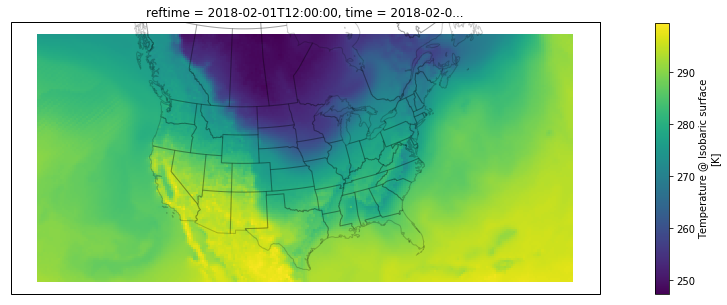

In [4]:
data_crs = data['Temperature_isobaric'].metpy.cartopy_crs
fig, ax = plt.subplots(figsize=(20,5), subplot_kw=dict(projection=data_crs))
data['Temperature_isobaric'].metpy.sel(vertical=1000 * units.hPa, time='2018-02-01 12:00').plot(ax=ax)
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='k', alpha=0.2, zorder=2)

In [5]:
data['lat']

<xarray.DataArray 'lat' (y: 120, x: 260)>
array([[20.062793, 20.157199, 20.250844, ..., 13.450693, 13.321145, 13.191172],
       [20.303797, 20.398707, 20.492853, ..., 13.65808 , 13.527905, 13.397305],
       [20.545123, 20.64054 , 20.735188, ..., 13.865643, 13.734839, 13.603608],
       ...,
       [48.965973, 49.138099, 49.309089, ..., 37.445334, 37.228601, 37.011456],
       [49.201215, 49.374183, 49.546013, ..., 37.63129 , 37.413739, 37.195778],
       [49.435855, 49.609667, 49.782341, ..., 37.816568, 37.598198, 37.37942 ]])
Coordinates:
  * x        (x) float32 -3227081.8 -3194618.8 ... 5148372.5 5180835.5
  * y        (y) float32 -2856844.2 -2824381.0 -2791918.2 ... 973790.0 1006253.0
    lat      (y, x) float64 20.06 20.16 20.25 20.34 ... 38.03 37.82 37.6 37.38
    lon      (y, x) float64 -135.0 -134.8 -134.5 -134.3 ... -42.1 -41.87 -41.64
    crs      object Projection: lambert_conformal_conic
Attributes:
    units:                degrees_north
    standard_name:        latitud

In [43]:
time = '2018-02-01 12:00'

# Perform calculations
heights = data['Geopotential_height_isobaric']
f = mpcalc.coriolis_parameter(data['lat'])[None, None, :, :]
dx, dy = mpcalc.grid_deltas_from_dataarray(heights)
ug, vg = mpcalc.geostrophic_wind(heights, f, dx, dy)

In [44]:
temperature, pressure, specific_humidity = xr.broadcast(data['Temperature_isobaric'],
                                                        data['isobaric'],
                                                        data['Specific_humidity_isobaric'])
rh = mpcalc.relative_humidity_from_specific_humidity(specific_humidity, temperature, pressure)
dewpoint = mpcalc.dewpoint_from_specific_humidity(specific_humidity, temperature, pressure)

theta_e = mpcalc.equivalent_potential_temperature(pressure, temperature, dewpoint)
vert_abs_vort = f + mpcalc.vorticity(ug, vg, dx, dy)

In [45]:
data['theta_e'] = xr.DataArray(theta_e,
                               coords=heights.coords,
                               dims=heights.dims,
                               attrs={'units': theta_e.units})
data['u_g'] = xr.DataArray(ug,
                           coords=heights.coords,
                           dims=heights.dims,
                           attrs={'units': ug.units})
data['v_g'] = xr.DataArray(vg,
                           coords=heights.coords,
                           dims=heights.dims,
                           attrs={'units': vg.units})

In [46]:
data['rh'] = xr.DataArray(rh,
                           coords=heights.coords,
                           dims=heights.dims,
                           attrs={'units': rh.units})
data['rh'].metpy.convert_units('percent')

In [47]:
data

<xarray.Dataset>
Dimensions:                                  (isobaric: 29, time: 9, x: 260, y: 120)
Coordinates:
    reftime                                  (time) datetime64[ns] 2018-02-01 ... 2018-02-02
  * x                                        (x) float32 -3227081.8 ... 5180835.5
  * y                                        (y) float32 -2856844.2 ... 1006253.0
  * time                                     (time) datetime64[ns] 2018-02-01 ... 2018-02-02
  * isobaric                                 (isobaric) float64 100.0 ... 1e+03
    lat                                      (y, x) float64 20.06 ... 37.38
    lon                                      (y, x) float64 -135.0 ... -41.64
    crs                                      object Projection: lambert_conformal_conic
Data variables:
    Pressure_Vertical_velocity_isobaric      (time, isobaric, y, x) float32 ...
    Temperature_isobaric                     (time, isobaric, y, x) float32 ...
    Specific_humidity_isobaric       

In [48]:
data['rh']

<xarray.DataArray 'rh' (time: 9, isobaric: 29, y: 120, x: 260)>
array([[[[ 7.877834, ..., 29.061266],
         ...,
         [ 0.474508, ...,  5.992105]],

        ...,

        [[87.111698, ..., 80.917029],
         ...,
         [87.199233, ..., 77.829387]]],


       ...,


       [[[ 5.52356 , ..., 32.669004],
         ...,
         [ 0.385752, ...,  3.552802]],

        ...,

        [[88.737129, ..., 75.260794],
         ...,
         [95.057503, ..., 82.559577]]]])
Coordinates:
    reftime   (time) datetime64[ns] 2018-02-01 ... 2018-02-02
  * x         (x) float32 -3227081.8 -3194618.8 ... 5148372.5 5180835.5
  * y         (y) float32 -2856844.2 -2824381.0 ... 973790.0 1006253.0
  * time      (time) datetime64[ns] 2018-02-01 ... 2018-02-02
  * isobaric  (isobaric) float64 100.0 125.0 150.0 175.0 ... 950.0 975.0 1e+03
    lat       (y, x) float64 20.06 20.16 20.25 20.34 ... 38.03 37.82 37.6 37.38
    lon       (y, x) float64 -135.0 -134.8 -134.5 -134.3 ... -42.1 -41.87 -41.64
   

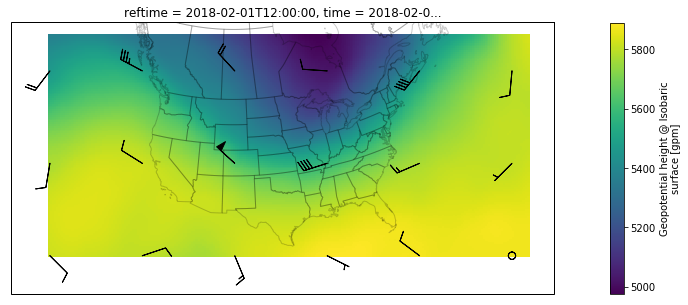

In [49]:
subset = data.metpy.sel(time=time, isobaric=500 * units.hPa)
fig, ax = plt.subplots(figsize=(20,5), subplot_kw=dict(projection=data_crs))
subset['Geopotential_height_isobaric'].plot(ax=ax)
u = subset['u_g']
v = subset['v_g']
x, y = u.metpy.coordinates('x', 'y')
select = slice(None, None, 50)
ax.barbs(x[select], y[select], u[select, select], v[select, select])
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='k', alpha=0.2, zorder=2)
plt.show()

In [50]:
dtheta_e_dp, dtheta_e_dy, dtheta_e_dx = (var.metpy.unit_array for var in mpcalc.gradient(data['theta_e'], axes=('vertical', 'y', 'x')))
dug_dp = mpcalc.first_derivative(data['u_g'], axis='vertical').metpy.unit_array
dvg_dp = mpcalc.first_derivative(data['v_g'], axis='vertical').metpy.unit_array
dz_dp = mpcalc.first_derivative(data['Geopotential_height_isobaric'], axis='vertical').metpy.unit_array

In [51]:
mpv = g * (1 / dz_dp) * (-dvg_dp * dtheta_e_dx + dug_dp * dtheta_e_dy + vert_abs_vort * dtheta_e_dp)

In [52]:
mpv.max(), mpv.mean(), mpv.min(), mpv.std()

(<Quantity(0.00039547126035199246, 'kelvin / second ** 3')>,
 <Quantity(4.047797227268933e-06, 'kelvin / second ** 3')>,
 <Quantity(-0.0003851517760391743, 'kelvin / second ** 3')>,
 <Quantity(1.0845338432764854e-05, 'kelvin / second ** 3')>)

In [53]:
data['mpv'] = xr.DataArray(mpv,
                           coords=heights.coords,
                           dims=heights.dims,
                           attrs={'units': mpv.units})
data['mpv'].metpy.convert_units('microkelvin / s^3')

In [54]:
start = (35.49, -111.17)
end = (42.75, -98.26)

In [55]:
cross = cross_section(data.sel(time=time), start, end)

In [56]:
cross

<xarray.Dataset>
Dimensions:                                  (index: 100, isobaric: 29)
Coordinates:
    reftime                                  datetime64[ns] 2018-02-01T12:00:00
    time                                     datetime64[ns] 2018-02-01T12:00:00
  * isobaric                                 (isobaric) float64 100.0 ... 1e+03
    lat                                      (index) float64 35.49 ... 42.75
    lon                                      (index) float64 -111.2 ... -98.26
    crs                                      object Projection: lambert_conformal_conic
    x                                        (index) float64 -3.885e+05 ... 7.171e+05
    y                                        (index) float64 -1.618e+06 ... -7.659e+05
  * index                                    (index) int64 0 1 2 3 ... 97 98 99
Data variables:
    Pressure_Vertical_velocity_isobaric      (isobaric, index) float64 -0.03118 ... 0.01984
    Temperature_isobaric                     (isobari

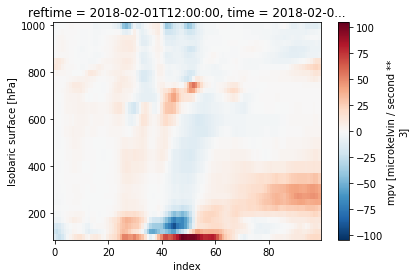

In [57]:
cross['mpv'].plot()

In [58]:
plt.close()

In [59]:
momentum = mpcalc.absolute_momentum(cross['u_g'], cross['v_g'])
print(momentum)

<xarray.DataArray (isobaric: 29, index: 100)>
array([[125.385938, 122.74618 , 120.136569, ...,  81.058598,  81.382169,
         81.720505],
       [121.357594, 118.286225, 115.648805, ...,  77.753756,  78.219216,
         78.914308],
       [119.654559, 116.379984, 113.44996 , ...,  74.913288,  75.626414,
         75.981311],
       ...,
       [145.028151, 145.666248, 146.618955, ..., 100.727893, 100.923846,
        100.736723],
       [147.087985, 147.596429, 147.998006, ..., 101.771015, 102.217413,
        102.597688],
       [147.873402, 147.990474, 148.062657, ..., 105.112548, 105.638732,
        105.355884]])
Coordinates:
    reftime   datetime64[ns] 2018-02-01T12:00:00
    time      datetime64[ns] 2018-02-01T12:00:00
  * isobaric  (isobaric) float64 100.0 125.0 150.0 175.0 ... 950.0 975.0 1e+03
    lat       (index) float64 35.49 35.57 35.65 35.73 ... 42.62 42.68 42.75
    lon       (index) float64 -111.2 -111.1 -110.9 ... -98.55 -98.4 -98.26
    crs       object Projection: lam

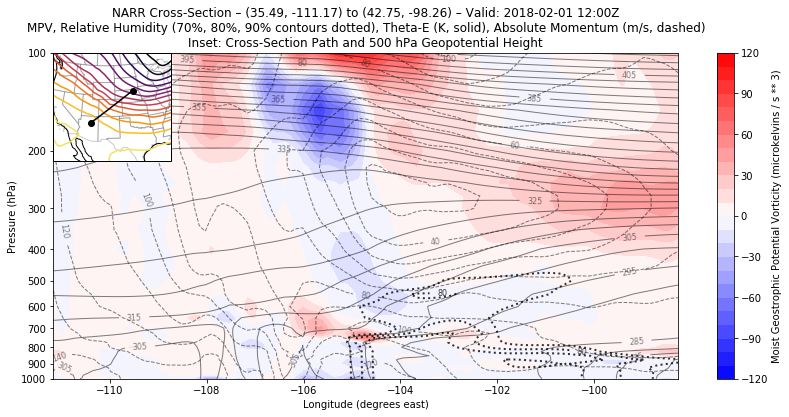

In [60]:
# Define the figure object and primary axes
fig = plt.figure(1, figsize=(14., 6.))
ax = plt.axes()

# Plot MPV using contourf
mpv_contour = ax.contourf(cross['lon'], cross['isobaric'], cross['mpv'],
                         levels=np.arange(-120, 121, 10), cmap='bwr')
mpv_colorbar = fig.colorbar(mpv_contour)

# Plot theta-e using contour, with some custom labeling
thetae_contour = ax.contour(cross['lon'], cross['isobaric'], cross['theta_e'],
                           levels=np.arange(250, 450, 5), colors='k', linewidths=1,
                           linestyles='-', alpha=0.5, zorder=2)
thetae_contour.clabel(thetae_contour.levels[1::2], fontsize=8, colors='k', inline=1,
                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot RH using contour, with some custom labeling
rh_contour = ax.contour(cross['lon'], cross['isobaric'], cross['rh'],
                           levels=np.arange(70, 100, 10), colors='k', linewidths=2,
                           linestyles=':', alpha=0.8, zorder=3)
rh_contour.clabel(rh_contour.levels[1::2], fontsize=8, colors='k', inline=1,
                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot theta-e using contour, with some custom labeling
thetae_contour = ax.contour(cross['lon'], cross['isobaric'], momentum,
                           levels=np.arange(0, 150, 10), colors='k', linewidths=1,
                           linestyles='--', alpha=0.5, zorder=2)
thetae_contour.clabel(thetae_contour.levels[1::2], fontsize=8, colors='k', inline=1,
                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)

# Adjust the y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_yticklabels(np.arange(1000, 50, -100))
ax.set_ylim(cross['isobaric'].max(), cross['isobaric'].min())
ax.set_yticks(np.arange(1000, 50, -100))

# Define the CRS and inset axes
ax_inset = fig.add_axes([0.058, 0.630, 0.25, 0.25], projection=data_crs)

# Plot geopotential height at 500 hPa using xarray's contour wrapper
ax_inset.contour(data['x'], data['y'], data['Geopotential_height_isobaric'].sel(time=time, isobaric=500.),
                 levels=np.arange(5100, 6000, 60), cmap='inferno')

# Plot the path of the cross section
endpoints = data_crs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start, end]).transpose()[::-1])
ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
ax_inset.plot(cross['x'], cross['y'], c='k', zorder=2)
pad = 1e6
ax_inset.set_extent([cross['x'][0] - pad, cross['x'][-1] + pad,
                     cross['y'][0] - pad, cross['y'][-1] + pad], crs=data_crs)

# Add geographic features
ax_inset.coastlines()
ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='k', alpha=0.2, zorder=0)

# Set the titles and axes labels
ax_inset.set_title('')
ax.set_title('NARR Cross-Section \u2013 {} to {} \u2013 Valid: {}\n'
             'MPV, Relative Humidity (70%, 80%, 90% contours dotted), Theta-E (K, solid), '
             'Absolute Momentum (m/s, dashed)\n'
             'Inset: Cross-Section Path and 500 hPa Geopotential Height'.format(
                 start, end, cross['time'].dt.strftime('%Y-%m-%d %H:%MZ').item()))
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Longitude (degrees east)')
mpv_colorbar.set_label('Moist Geostrophic Potential Vorticity (microkelvins / s ** 3)')

plt.savefig('../poster/figures/csi_example_narr.pdf', bbox_inches='tight')

In [42]:
momentum.min()

<xarray.DataArray ()>
array(33.26589)
Coordinates:
    reftime  datetime64[ns] 2018-02-01T06:00:00
    time     datetime64[ns] 2018-02-01T06:00:00
    crs      object Projection: lambert_conformal_conic

In [ ]:
ax.contourf()